# Lorenz-63 model
In this Notebook we'll demonstrate how to construct multivariate models. To this end, we shall consider the Lorenz-63 model, defined as 
\begin{equation}
    \begin{cases}
        \mathrm{d}X^1_t = -S (X^1_t - X^2_t) \mathrm{d}t + \mathrm{d}W^1_t, \\
        \mathrm{d}X^2_t = (RX^1_t - X^2_t - X^1_t \cdot X^2_t) \mathrm{d}t + \mathrm{d}W^2_t, \\
        \mathrm{d}X^3_t = (X^1_t \cdot X^2_t - BX^3_t) \mathrm{d}t + \mathrm{d}W^3_t,
    \end{cases}
\end{equation}
where $\{W^i_t\}$ are 1-dimensional Wienere processes and $(S, R, B) \in \mathbb{R}^3$. We assume that we collect discrete observations of the above system via the following set of equations
\begin{equation}
    \begin{cases}
        Y^1_t = k_o X^1_t + V^1_t, \\
        Y^2_t = k_o X^3_t + V^2_t,
    \end{cases}
\end{equation}
where $k_o > 0$, and $V^i_t \sim \mathcal{N}(0, \sigma^2)$ where $\sigma^2 = 0.1$. We proceed in the same manner as the Stochastic volatility example and import the necessary packages.

In [1]:
from pyfilter.timeseries import StateSpaceModel, AffineEulerMaruyama, LinearGaussianObservations

Next, we define the inital distributions as
\begin{equation}
X^1_0 \sim \mathcal{N}(-5.9162, 10), \quad X^2_0 \sim \mathcal{N}(-5.52332, 10), \quad X^3_0 \sim \mathcal{N}(24.5723, 10),
\end{equation}
which means that the model equations are given by

In [2]:
import torch
import math
from pyfilter.utils import concater


def f(x, s, r, b):
    x1 = -s * (x[..., 0] - x[..., 1])
    x2 = r * x[..., 0] - x[..., 1] - x[..., 0] * x[..., 2]
    x3 = x[..., 0] * x[..., 1] - b * x[..., 2]

    return concater(x1, x2, x3)


def g(x, s, r, b):
    return torch.ones(3, device=x.device)

For this example we'll simulate data, we do this by setting $(S, R, B) \triangleq (10, 28, 8/3)$ and assume that we get observations every 0.10 seconds, and solve the SDE using $\Delta t = 0.01$. So, for every observations we've made 10 time steps.

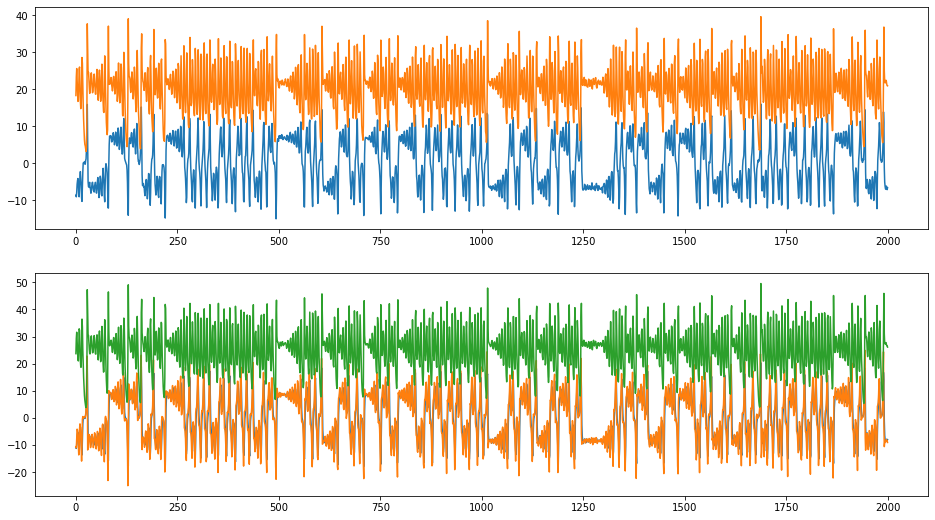

In [3]:
import matplotlib.pyplot as plt
from torch.distributions import Independent, Normal, Uniform, MultivariateNormal
from pyfilter.distributions import DistributionWrapper

# ===== Initial ===== #
mean = torch.tensor([-5.91652, -5.52332, 24.5723])
scale = math.sqrt(10) * torch.ones(3)
init_dist = DistributionWrapper(lambda **u: Independent(Normal(**u), 1), loc=mean, scale=scale) 

# ===== Incremental ===== #
dt = 1e-2
inc = DistributionWrapper(
    lambda **u: Independent(Normal(**u), 1), 
    loc=torch.zeros_like(mean), 
    scale=math.sqrt(dt) * torch.ones_like(mean)
) 

hidden = AffineEulerMaruyama((f, g), (10., 28., 8/3), init_dist, inc, dt=dt, num_steps=10)

mat = torch.tensor([
    [0.8, 0., 0.],
    [0., 0., 0.8]
])

simmodel = LinearGaussianObservations(hidden, mat, torch.ones(2) / math.sqrt(10))

x, y = simmodel.sample_path(2000)

fig, ax = plt.subplots(2, figsize=(16, 9))

ax[1].plot(x.numpy())
ax[0].plot(y.numpy())

Where the upper plot is the observble data, and the lower is the hidden processes. Next, we shall perform the inference. We use NESS to target the parameters. However, since the model has purely additive noise (rather than multiplicative) in the observational process, we may use the `Unscented Kalman Filter` to target the latent process. Furthermore, we use the same priors as in the original paper describing the NESS algorithm. Such that we get

In [10]:
from pyfilter.inference.sequential import NESS
from pyfilter.filters import UKF
from pyfilter.distributions import Prior

priors = Prior(Uniform, low=5.0, high=40.0), Prior(Uniform, low=10.0, high=50.0), Prior(Uniform, low=1.0, high=20.0)
hidden = AffineEulerMaruyama((f, g), priors, init_dist, inc, dt=dt, num_steps=10)
ssm = LinearGaussianObservations(hidden, mat, torch.ones(2) / math.sqrt(10))

algs = list()
for i in range(2):
    filt_ = UKF(ssm.copy())
    alg = NESS(filt_, 500).to("cuda:0")
    
    state = alg.fit(y)
    algs.append([state, alg])

  0%|                                                                                         | 0/2000 [00:00<?, ?it/s]


RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu!

Let's plot the filter means together with the hidden states for last 100 observations.

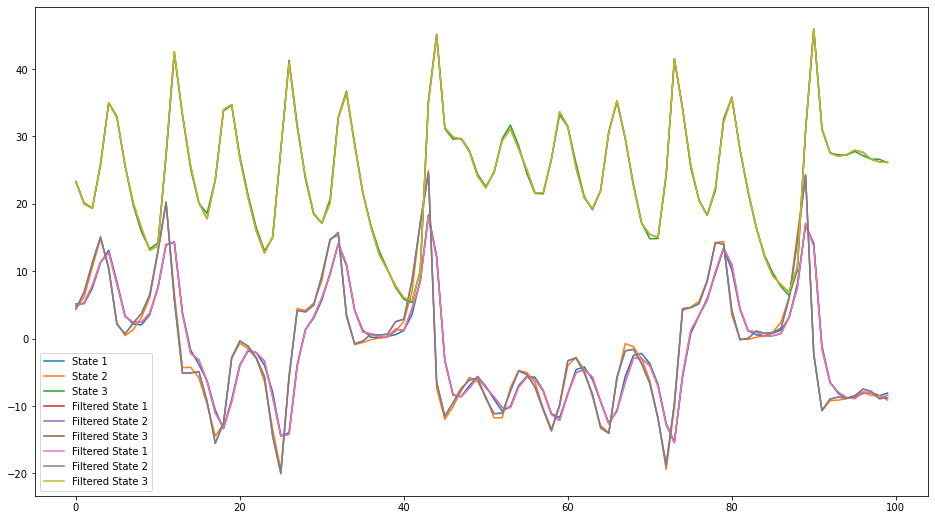

In [8]:
import pandas as pd

fig, ax = plt.subplots(figsize=(16, 9))

states = ['State 1', 'State 2', 'State 3']
pd.DataFrame(x[-100:].numpy(), columns=states).plot(ax=ax)

for state, _ in algs:
    pd.DataFrame(state.filter_state.filter_means.mean(dim=1)[-100:].numpy(), columns=[f'Filtered {s}' for s in states]).plot(ax=ax)

And finally we plot the posterior distributions together with the true parameters

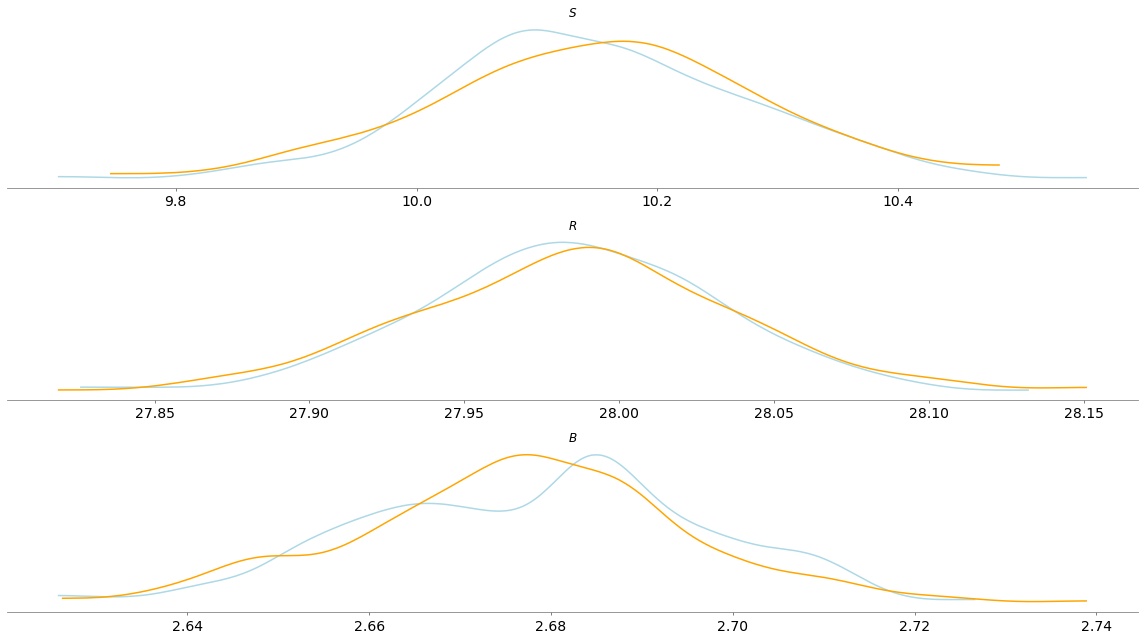

In [9]:
from pyfilter.utils import normalize
from arviz import plot_posterior
from pyfilter.resampling import systematic

fig, ax = plt.subplots(3, figsize=(16, 9))
colors = ["lightblue", "orange"]
names = "S, R, B".split(", ")

for j, (state, alg) in enumerate(algs):
    w = normalize(state.w)
    inds = systematic(w)
    
    for i, param in enumerate(alg.filter.ssm.parameters()):    
        plot_posterior(param[inds].numpy(), ax=ax[i], color=colors[j], point_estimate=None, hdi_prob='hide')
        
        ax[i].set_title(f"${names[i]}$")
        
plt.tight_layout()